Carregando tabelas...
{'ALPHA': 0.1, 'ALPHA_gc': 50.0, 'Area': 10386.890710931251, 'B_dt': 755.49, 'B_r': 7.11, 'B_g': 45.6, 'CP_max': 0.486, 'D_max': 1000.0, 'ETA_dt': 0.97, 'ETA_gc': 0.98, 'f_s': 0.0001, 'H': 81.0, 'J_r': 55000000.0, 'J_g': 390.0, 'K_dt': 2700000000.0, 'K_opt': 1.2171, 'k_i': 1.0, 'k_p': 4.0, 'LAMBDA_opt': 7.6, 'N_g': 95.0, 'OMEGA_n': 11.11, 'OMEGA_nom': 162.0, 'OMEGA_var': 15.0, 'PI': 3.141592653589793, 'PHI_opt': 0.0, 'P_r': 4800000.0, 'r_0': 1.5, 'R': 57.5, 'RHO': 1.225, 'T_s': 0.01, 'Ts_RUL': 10.0, 'T_desired': 1.23, 'lowerVt': 0.2, 'upperVt': 5.0, 'ZETA': 0.6}
Iniciando Simulação Numba para 440001 passos...
kgain: [0.41496218 0.00954263]
t_ref 1.23
Tempo de Execução: 1.6787 segundos


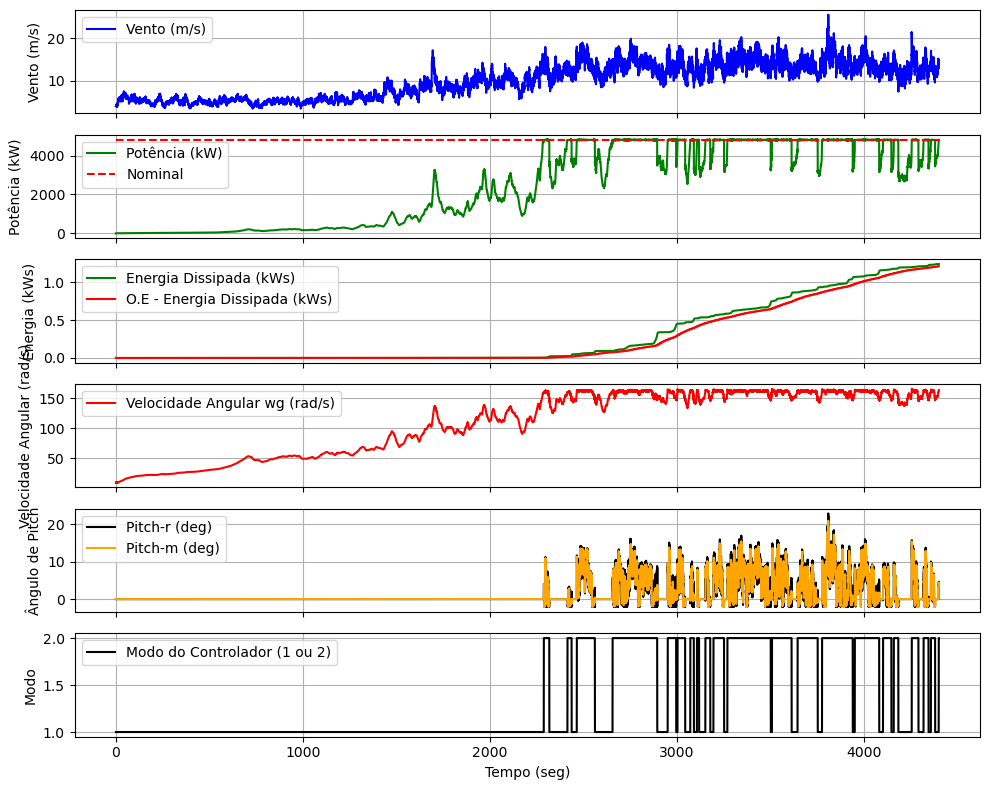

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control as ct
import cvxpy as cp
from scipy.linalg import sqrtm
import mosek
from numba import njit
import time
from _GraphUtils import *

def solve_lmi_gain(c, Ts, Q=np.diag([1, 2.5e-5]), R=np.array([[100.0]])):
        """
        Calcula o ganho ótimo do observador L usando a solução LMI para o problema LQ
        proposto na Seção 4.4.3 do artigo.

        Args:
            Q (np.array): Matriz de custo do estado (process noise covariance).
            R (np.array): Matriz de custo da medição (measurement noise covariance).
        """
        H = np.diag([1,1]) + Ts * np.array([[0,1],[0,-c]])
        C = np.array([[1,0]])
        n = H.shape[0] # Dimensão do estado (n=2)
        p = C.shape[0] # Dimensão da saída (p=1)

        # ---- Formulação do Problema LMI (Seção 4.4.3) ----
        # 1. Definir as variáveis da LMI
        # P: Matriz de Lyapunov (simétrica, definida positiva)
        P = cp.Variable((n, n), PSD=True)
        # Y: Variável de mudança para L (L = inv(P) * Y^T)
        Y = cp.Variable((p, n))
        # W: Limite superior para a função de custo
        W = cp.Variable((n + p, n + p), symmetric=True)

        # 2. Definir as matrizes de custo estendidas M e N (Equação 56)
        M = np.vstack([sqrtm(Q), np.zeros((p, n))])
        N = np.vstack([np.zeros((n, p)), sqrtm(R)])

        # 3. Definir as restrições (constraints) da LMI
        #constraints = [P >> 1e-16*np.eye(n)] # P deve ser definida positiva
        constraints = [P >> 1e-8]

        # Restrição de estabilidade (Equação 58, adaptada da condição de Lyapunov)
        # Esta é a LMI principal que garante a convergência do erro de estimação.
        lmi_stability = cp.bmat([
            [           (-P+Q), (H.T @ P - C.T @ Y)],
            [(P.T @ H - Y.T @ C),                -P]
        ])
        constraints += [lmi_stability << -1e-8]

        # Restrição da função de custo (Equação 61)
        lmi_cost = cp.bmat([
            [                      W, (M @ P + N @ Y)],
            [(P.T @ M.T + Y.T @ N.T),               P]
        ])
        constraints += [lmi_cost >> 1e-8]
        
        # 4. Definir o problema de otimização (Equação 62)
        # Minimizar o traço de W, que minimiza a função de custo do erro.
        objective = cp.Minimize(cp.trace(W))
        problem = cp.Problem(objective, constraints)

        # 5. Resolver o problema
        problem.solve(solver=cp.MOSEK)
        
        if problem.status not in ["infeasible", "unbounded"]:
            # Calcular o ganho L a partir das variáveis da solução
            # L = (inv(P) * Y^T)
            P_val = P.value
            Y_val = Y.value
            L_val = np.linalg.inv(P_val) @ Y_val.T
            L = (L_val.flatten()).reshape(-1,1)
            #print(f"Ganho L calculado com sucesso: {self.L}")
            
        else:
            print(f"Falha ao resolver a LMI. Status: {problem.status}")
        return H, L, C

def solve_lqr_gain(Q=np.diag([1, 1]), R_=np.array([[1e-5]]), **params):
        """
        Calcula os ganhos ótimos K1 e K2 usando a solução LMI para o problema
        de LQR Robusto descrito na Seção 4.4.2 do artigo.
        
        Args:
            Q (np.array): Matriz de custo do estado (2x2).
            R (np.array): Matriz de custo do controlo (1x1).
        """
        print(params)
        LAMBDA_opt, B_dt,  Rr = params['LAMBDA_opt'], params['B_dt'], params['R']
        vwL, vwU = params['lowerVt'], params['upperVt']
        gamma_min = (B_dt*(vwL**2))*2*LAMBDA_opt/(Rr**2)
        gamma_max = (B_dt*(vwU**2))*2*LAMBDA_opt/(Rr**2)

        n = 2 # Dimensão do estado x_k = [u_{k-1}, z_k]
        m = 1 # Dimensão da entrada u_k

        # --- Formulação do Problema LMI (Seção 4.4.2) ----
        # 1. Definir as variáveis da LMI
        P = cp.Variable((n, n), PSD=True)
        Y = cp.Variable((m, n))
        W = cp.Variable((n + m, n + m), symmetric=True)

        # 2. Definir as matrizes de custo estendidas M e N (Equação 39)
        M = np.vstack([sqrtm(Q), np.zeros((m, n))])
        N = np.vstack([np.zeros((n, m)), sqrtm(R_)])

        # 3. O sistema politópico tem 2 vértices (extremos de ~γ)
        # Vértice 1: Corresponde a gamma_min
        # Vértice 2: Corresponde a gamma_max
        A_vertices = [
            np.array([[0, 0], [gamma_min, 1]]),
            np.array([[0, 0], [gamma_max, 1]])
        ]
        B = np.array([[1], [0]])

        # 4. Definir as restrições da LMI para TODOS os vértices
        constraints = [P >> 1e-8] # P deve ser definida positiva

        for A in A_vertices:
            # Restrição de estabilidade (Equação 44)
            lmi_stability = cp.bmat([
                [               (-P+Q), (A @ P - B @ Y)],
                [(P @ A.T - Y.T @ B.T),              -P]
            ])
            constraints += [lmi_stability << -1e-8]

        # Restrição da função de custo (Equação 47)
        lmi_cost = cp.bmat([
            [                    W, (M @ P + N @ Y)],
            [(P @ M.T + Y.T @ N.T),               P]
        ])
        constraints += [lmi_cost >> 1e-8]
        
        # 5. Definir e resolver o problema de otimização
        objective = cp.Minimize(cp.trace(W))
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.MOSEK,verbose=False)

        # 6. Calcular os ganhos K a partir da solução
        if problem.status in ["infeasible", "unbounded"] or P.value is None:
            print(f"Falha ao resolver a LMI do LQR. Status: {problem.status}")
            return None

        P_val = P.value
        Y_val = Y.value
        
        # K = Y * inv(P)
        K_val = Y_val @ np.linalg.inv(P_val)
        K = (K_val.flatten())
        return K
        

# ==========================================
# 1. Funções Compiladas (Numba JIT)
# ==========================================

@njit(fastmath=True)
def get_coeff(lambda_val, phi_val, tsr_axis, pitch_axis, data_table):
    """
    Substitui Cp_calc e Cq_calc.
    Realiza busca rápida na tabela pré-carregada.
    """
    # Encontrar índice mais próximo para TSR (Lambda)
    # Assume que tsr_axis está ordenado
    idx1 = np.argmin(np.abs(tsr_axis - lambda_val))
    
    # Encontrar índice mais próximo para Pitch (Phi)
    idx2 = np.argmin(np.abs(pitch_axis - phi_val))
    
    return data_table[idx1, idx2]

@njit(fastmath=True)
def simulation_core(N_steps, v_wind, 
                    hawt_Ad, hawt_Bd, hawt_X_init,
                    gtc_Ad, gtc_Bd, gtc_Cd, gtc_Dd,
                    pac_Ad, pac_Bd, pac_Cd, pac_Dd,
                    dso_Ad, dso_Bd, fbc_Ad, fbc_Bd,
                    R, RHO, Area, N_g, PI, P_r, D_max, t_ref,
                    lambda_opt, eta_gc, omega_nom, omega_var,
                    k_p, k_i, B_dt, Ts, Ts_RUL, vwL, vwU,
                    tsr_axis, pitch_axis, cp_table, cq_table, K_gain):
    print('t_ref',t_ref)
    
    #print('dso_Bd L:',dso_Bd)
    #print('C:',dso_C)
    #print('hawt_Ad:',hawt_Ad)

    # --- Pré-alocação de Arrays (Velocidade Extrema) ---
    #print('B_dt:',B_dt)
    w_r_hist = np.zeros(N_steps)
    w_g_hist = np.zeros(N_steps)
    theta_s_hist = np.zeros(N_steps)
    tau_r_hist = np.zeros(N_steps)
    tau_g_hist = np.zeros(N_steps)
    phi_m_hist = np.zeros(N_steps)
    phi_r_hist = np.zeros(N_steps)
    P_g_hist = np.zeros(N_steps)
    P_d_hist = np.zeros(N_steps)
    E_g_hist = np.zeros(N_steps)
    E_d_hist = np.zeros(N_steps)
    hD_hist = np.zeros(N_steps)
    hB_hist = np.zeros(N_steps)
    Br_hist = np.zeros(N_steps)
    time_hist = np.zeros(N_steps)
    u_k_hist = np.zeros(N_steps)
    vtil_hist = np.zeros(N_steps)
    mode_hist = np.zeros(N_steps) # 1.0 para mode1, 2.0 para mode2
    
    # --- Inicialização de Estados ---
    # HAWT: [wr, wg, theta]
    x_hawt = hawt_X_init.astype(np.float64).copy()
    
    # GTC: [estado]
    x_gtc = np.array([0.0])
    
    # PAC: [estado1, estado2]
    x_pac = np.array([0.0, 0.0])

    # DSO: [estado1, estado2]
    x_dso = np.array([1e-3, 1e-3])

    # DSO: [estado1, estado2]
    x_fbc = np.array([1, 1e-3])
    z_k = 0
    u_k = 0
    
    # Variáveis de Controle
    phi_ref_prev = 0.0
    error_prev = 0.0
    current_mode = 1 # Começa no modo 1
    
    for k in range(N_steps):
        v = v_wind[k]
        
        # Leitura dos estados atuais do HAWT
        w_r = x_hawt[0]
        w_g = x_hawt[1]
        theta_s = x_hawt[2]
        
        # --- 1. Power Controller Logic (PWC) ---
        epsilon = w_g - omega_nom
        
        """ # Hysteresis simples para troca de modo (exemplo)
        # Se passar da velocidade nominal + tolerância, vai para Mode 2
        if current_mode == 1 and w_g >+ (omega_nom + 1.0):
            current_mode = 2
        elif current_mode == 2 and w_g < (omega_nom - 1.0):
            current_mode = 1
            phi_ref_prev = 0.0 # Resetar pitch ao voltar para torque control """
            
        tau_gr = 0.0
        phi_ref = 0.0
        
        if current_mode == 1:
            # Mode 1: Maximização de Cp (Torque quadrático)
            # u_k assumido 0
            lambda_calc = lambda_opt + u_k
            
            # Busca Cp na tabela (Pitch = 0)
            C_p = get_coeff(lambda_calc, 0.0, tsr_axis, pitch_axis, cp_table)
            
            K_opt = RHO * Area * (R**3) * C_p / (2 * (lambda_calc**3) * N_g)
            tau_gr = K_opt * ((w_g / N_g)**2)
            
            phi_ref = 0.0
            phi_ref_prev = 0.0 # Manter rastreio
            error_prev = epsilon # Atualizar erro para transição suave
            
        else: # Mode 2
            # Mode 2: Controle de Potência/Velocidade via Pitch
            # Torque mantém potência constante
            if w_g > 0.1:
                tau_gr = P_r / (eta_gc * w_g)
            else:
                tau_gr = 0.0
                
            # PI Controller para Pitch (Algoritmo de Velocidade/Incremental)
            # phi_ref = phi_prev + kp*e + (ki*Ts - kp)*e_prev
            delta_u = k_p * epsilon + (k_i * Ts - k_p) * error_prev
            phi_ref = phi_ref_prev + delta_u
            
            # Saturação do Pitch (0 a 90 graus)
            #if phi_ref < 0: phi_ref = 0
            #if phi_ref > 90: phi_ref = 90

            if phi_ref < -2: phi_ref = -2
            if phi_ref > 95: phi_ref = 95
            
            # Atualiza memórias do controlador
            phi_ref_prev = phi_ref
            error_prev = epsilon

        # --- 2. Generator Torque Converter (GTC) ---
        u_gtc = np.array([tau_gr])
        # Y = C*x + D*u
        y_gtc = (gtc_Cd @ x_gtc + gtc_Dd @ u_gtc)[0]
        tau_g_applied = y_gtc
        
        P_g = eta_gc * w_g * tau_g_applied
        P_d = B_dt * ((w_r-(w_g/N_g))**2) *(1+1-eta_gc)
        if k < 1:
            E_g = P_g
            E_d = P_d
        else:
            E_g = E_g_hist[k-1] + P_g
            E_d = E_d_hist[k-1] + P_d

        # Hysteresis simples para troca de modo (exemplo)
        # Se passar da velocidade nominal + tolerância, vai para Mode 2
        if current_mode == 1 and w_g >= (omega_nom) or P_g >= P_r:
            current_mode = 2
        elif current_mode == 2 and w_g < (omega_nom - omega_var):
            current_mode = 1
            phi_ref_prev = 0.0 # Resetar pitch ao voltar para torque control
        
        # Atualiza estado GTC: X_new = A*x + B*u
        x_gtc = gtc_Ad @ x_gtc + gtc_Bd @ u_gtc
        
        # --- 3. Pitch Angle Controller (PAC) ---
        u_pac = np.array([phi_ref])
        y_pac = (pac_Cd @ x_pac + pac_Dd @ u_pac)[0]
        phi_m = y_pac
        
        # Atualiza estado PAC
        x_pac = pac_Ad @ x_pac + pac_Bd @ u_pac
        
        # --- 4. Aerodynamic Model (ADM) ---
        if v < 0.1:
            lamb = 0.0
        else:
            lamb = w_r * R / v
            
        C_q = get_coeff(lamb, phi_m, tsr_axis, pitch_axis, cq_table)
        tau_r = RHO * PI * (R**3) * C_q * (v**2) / 2.0
        
        # --- 5. HAWT Dynamics (Plant) ---
        u_hawt = np.array([tau_r, tau_g_applied])
        
        # Atualiza estado HAWT (w_r, w_g, theta)
        x_hawt = hawt_Ad @ x_hawt + hawt_Bd @ u_hawt

        if k>0 and k%1000==0:

            # --- 7. Reference Converter ---
            RUL_ref = (t_ref*3600 - k*Ts)
            BETA_ref = (D_max - x_dso[0])/RUL_ref

            # --- 6. Degradation State Observer (DSO) ---
            x_dso = dso_Ad @ x_dso + dso_Bd @ np.array([E_d])
            dD, dBETA = x_dso[0], x_dso[1]
            
            
            # --- 8. Feedback Controller ---
            """ np.random.seed(k)
            vtil = np.random.normal(loc=2, scale=0.5, size=1)
            vtil = np.clip(vtil, vwL, vwU)[0]
            gamma = B_dt*(vtil**2)*2*lambda_opt/(R**2)
            fbc_Ad[1][0] = gamma
            delta_beta  = gamma * x_fbc[0]
            u_fbc = (K_gain @ x_fbc.reshape(-1,1))
            x_fbc = (fbc_Ad @ x_fbc + fbc_Bd @ x_fbc) + np.array([0,-1]) * delta_beta """
            z_k = z_k + (dBETA-BETA_ref)
            u_k = -K_gain[0]*u_k - K_gain[1]*z_k
        #u_k =0
        # --- Salvar Histórico ---
        w_r_hist[k] = w_r
        w_g_hist[k] = w_g
        theta_s_hist[k] = theta_s
        tau_r_hist[k] = tau_r
        tau_g_hist[k] = tau_g_applied
        phi_m_hist[k] = phi_m
        phi_r_hist[k] = phi_ref
        P_g_hist[k] = P_g
        P_d_hist[k] = P_d
        E_g_hist[k] = E_g
        E_d_hist[k] = E_d
        hD_hist[k] = x_dso[0]
        hB_hist[k] = x_dso[1]
        Br_hist[k] = BETA_ref 
        time_hist[k] = k*Ts
        #vtil_hist[k] = vtil
        u_k_hist[k] = u_k
        mode_hist[k] = current_mode
    #print('Ts:',Ts)
    return w_r_hist, w_g_hist, tau_r_hist, tau_g_hist, phi_m_hist, phi_r_hist, P_g_hist, P_d_hist, E_g_hist, E_d_hist, hD_hist, hB_hist, Br_hist, time_hist, vtil_hist, u_k_hist, mode_hist

# ==========================================
# 2. Preparação de Dados (Python Puro)
# ==========================================

def prepare_simulation():
    # --- Carregar CSVs ---
    print("Carregando tabelas...")
    try:
        # Tente carregar seus arquivos originais
        params_df = pd.read_csv(r'params2.csv')
        params = dict(zip(params_df['Parameter'], params_df['Value']))
        #print('params:',params)
        #path1 = r'Datasets/WindSpeed_V1.csv'
        #path = r'Datasets/WindSpeedML_v1.csv'

        paths = [r'Datasets/WindSpeed_V1.csv', r'Datasets/WindSpeed_V2.csv', r'Datasets/WindSpeedML_v1.csv']
        path = paths[2]

        df_wind = pd.read_csv(path)
        v = df_wind.iloc[:,0].values + 1
        #v = np.sqrt(np.flip(v) )*4*1.5
        v = np.sqrt((v) )*4*1.5

        if path.endswith('WindSpeedML_v1.csv'):
            v = df_wind.iloc[:,0].values 

        #if path.endswith('WindSpeed_V1.csv'):
        #    params['T_s'] = 1

        df_cp = pd.read_csv(r'Cp_R0.csv')
        df_cq = pd.read_csv(r'Cq_R0.csv')
        
        # Preparar Eixos e Tabelas para Numba
        # Assumindo estrutura do seu código original (Coluna 0 = TSR, Resto = Coeficientes por Pitch)
        tsr_axis = df_cp.iloc[:, 0].values.astype(np.float64)
        #tsr_axis = df_cp.iloc[1:, 0].values.astype(np.float64)
        
        # Ângulos hardcoded do seu script original
        angles = np.array([-2,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.5,2,3,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]).astype(np.float64)
        #angles = df_cp.iloc[0,1:].values

        # Extrair matrizes de dados (dropando coluna TSR)
        cp_table = df_cp.iloc[:, 1:].values.astype(np.float64)
        cq_table = df_cq.iloc[:, 1:].values.astype(np.float64)
        #cp_table = df_cp.iloc[1:, 1:].values.astype(np.float64)
        #cq_table = df_cq.iloc[1:, 1:].values.astype(np.float64)
        
    except FileNotFoundError:
        print("AVISO: Arquivos não encontrados. Usando dados fictícios para teste.")
        # Dados Dummy para o código rodar se você copiar e colar agora
        params = {
            'Area': 100, 'B_dt': 1, 'B_r': 1, 'B_g': 1, 'CP_max': 0.45, 'ETA_dt': 0.9, 'ETA_gc': 0.9,
            'J_r': 100, 'J_g': 10, 'K_dt': 1000, 'k_i': 1.0, 'k_p': 0.1, 'LAMBDA_opt': 8, 'N_g': 90,
            'OMEGA_n': 1, 'OMEGA_nom': 100, 'OMEGA_var': 1, 'PHI_opt': 0, 'P_r': 1000, 'PI': np.pi,
            'R': 40, 'RHO': 1.225, 'ALPHA_gc': 10, 'ZETA': 0.7
        }
        v = np.linspace(5, 15, 1000) # Vento rampa
        tsr_axis = np.linspace(0, 20, 100)
        angles = np.linspace(-2, 95, 33)
        cp_table = np.random.rand(100, 33) * 0.4
        cq_table = np.random.rand(100, 33) * 0.05

    Ts = 0.01 # Seu Time Step
    Ts = params['T_s']
    # --- Construção das Matrizes (Control Library) ---
    
    # 1. HAWT Matrices
    B_dt, B_r, B_g = params['B_dt'], params['B_r'], params['B_g']
    J_r, J_g, N_g = params['J_r'], params['J_g'], params['N_g']
    K_dt, ETA_dt = params['K_dt'], params['ETA_dt']
    
    A_hawt = np.array([
        [-(B_dt+B_r)/J_r, B_dt/(N_g*J_r), -K_dt/J_r],
        [(B_dt*ETA_dt)/(N_g*J_g), -(((B_dt*ETA_dt)/(N_g**2))+B_g)*(1/J_g), (K_dt*ETA_dt)/(N_g*J_g)],
        [1, -1/N_g, 0]
    ])
    B_hawt = np.array([
        [1/J_r, 0],
        [0, -1/J_g],
        [0, 0]
    ])
    
    sys_hawt = ct.c2d(ct.ss(A_hawt, B_hawt, np.eye(3), np.zeros((3,2))), Ts, method='zoh')
    
    # 2. GTC Matrices
    alpha_gc = params['ALPHA_gc']
    sys_gtc = ct.c2d(ct.ss(ct.tf([alpha_gc], [1, alpha_gc])), Ts, method='zoh')
    
    # 3. PAC Matrices
    omega_n, zeta = params['OMEGA_n'], params['ZETA']
    sys_pac = ct.c2d(ct.ss(ct.tf([omega_n**2], [1, 2*omega_n*zeta, omega_n**2])), Ts, method='zoh')

    # 4. Degradation State Observer
    Ts_RUL = params['Ts_RUL']
    H, L, C = solve_lmi_gain(10,Ts, Q=np.diag([1, 2.5e-5]), R=np.array([[100.0]]))
    A_dso = (H - L@C)
    B_dso = L
    sys_dso = ct.ss(A_dso, B_dso, np.zeros_like(A_dso), np.zeros_like(B_dso), Ts) #VERIFICAR Ts#
   
    # 5. Feedback Controller
    K_gain = solve_lqr_gain(**params)
    A_fbc = np.array([[0,0],[1,1]])
    B_fbc = np.array([[1],[0]]) @ np.array([-K_gain])
    sys_fbc = ct.ss(A_fbc,B_fbc,np.zeros_like(A_fbc), np.zeros_like(B_fbc), Ts) #VERIFICAR Ts#

    # Retorna tudo compactado para passar ao Numba
    # É crucial usar np.ascontiguousarray para performance máxima no Numba
    matrices = {
        'h_Ad': np.ascontiguousarray(sys_hawt.A), 'h_Bd': np.ascontiguousarray(sys_hawt.B),
        'g_Ad': np.ascontiguousarray(sys_gtc.A), 'g_Bd': np.ascontiguousarray(sys_gtc.B), 'g_Cd': np.ascontiguousarray(sys_gtc.C), 'g_Dd': np.ascontiguousarray(sys_gtc.D),
        'p_Ad': np.ascontiguousarray(sys_pac.A), 'p_Bd': np.ascontiguousarray(sys_pac.B), 'p_Cd': np.ascontiguousarray(sys_pac.C), 'p_Dd': np.ascontiguousarray(sys_pac.D),
        's_Ad': np.ascontiguousarray(sys_dso.A), 's_Bd': np.ascontiguousarray(sys_dso.B),
        'f_Ad': np.ascontiguousarray(sys_fbc.A), 'f_Bd': np.ascontiguousarray(sys_fbc.B),
    }
    
    return params, v, tsr_axis, angles, cp_table, cq_table, K_gain, matrices

# ==========================================
# 3. Execução Principal
# ==========================================

if __name__ == "__main__":
    
    # 1. Preparar
    params, v_wind, tsr_axis, pitch_axis, cp_table, cq_table, K_gain, mats = prepare_simulation()
    
    Ts = 0.01
    N_steps = len(v_wind[:])
    hawt_X_init = np.array([0.1, 0.1*params['N_g'], 0.0])

    print(f"Iniciando Simulação Numba para {N_steps} passos...")
    print('kgain:', K_gain)
    start_time = time.time()
    
    # 2. Rodar (A primeira execução compila, as próximas são instantâneas)
    results = simulation_core(
        N_steps, v_wind,
        mats['h_Ad'], mats['h_Bd'], hawt_X_init,
        mats['g_Ad'], mats['g_Bd'], mats['g_Cd'], mats['g_Dd'],
        mats['p_Ad'], mats['p_Bd'], mats['p_Cd'], mats['p_Dd'],
        mats['s_Ad'], mats['s_Bd'], mats['f_Ad'], mats['f_Bd'],
        params['R'], params['RHO'], params['Area'], params['N_g'], params['PI'],
        params['P_r'],params['D_max'],params['T_desired'],
        params['LAMBDA_opt'], params['ETA_gc'], params['OMEGA_nom'], params['OMEGA_var'],
        params['k_p'], params['k_i'], params['B_dt'], params['T_s'], params['Ts_RUL'], params['lowerVt'], params['upperVt'],
        tsr_axis, pitch_axis, cp_table, cq_table, K_gain
    )
    
    end_time = time.time()
    print(f"Tempo de Execução: {end_time - start_time:.4f} segundos")
    
    # 3. Desempacotar e Plotar
    wr, wg, tr, tg, phim, phir, Pg, Pd, Eg, Ed, hD, hB, Br, time_h, vtil, u_k, mode = results

    # Exemplo visualização
    fig, ax = plt.subplots(6, 1, figsize=(10, 8), sharex=True)
    
    ax[0].plot(time_h,v_wind, label='Vento (m/s)', color='blue')
    ax[0].set_ylabel('Vento (m/s)')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].plot(time_h,Pg/1000, label='Potência (kW)', color='green')
    ax[1].plot(time_h, [params['P_r']/1000 for i in range(N_steps)], 'r--', label='Nominal')
    ax[1].set_ylabel('Potência (kW)')
    ax[1].legend()
    ax[1].grid(True)

    ax[2].plot(time_h,Ed/1000, label='Energia Dissipada (kWs)', color='green')
    ax[2].plot(time_h,hD/1000, label='O.E - Energia Dissipada (kWs)', color='red')
    ax[2].set_ylabel('Energia (kWs)')
    ax[2].legend()
    ax[2].grid(True)
    
    ax[3].plot(time_h,wg, label='Velocidade Angular wg (rad/s)', color='red')
    #ax[3].plot(time_h,wr, label='Velocidade Angular wr (rad/s)', color='blue')
    ax[3].set_ylabel('Velocidade Angular (rad/s)')
    ax[3].legend()
    ax[3].grid(True)

    ax[4].plot(time_h,phir, label='Pitch-r (deg)', color='black')
    ax[4].plot(time_h,phim, label='Pitch-m (deg)', color='orange')
    ax[4].set_ylabel('Ângulo de Pitch')
    ax[4].legend()
    ax[4].grid(True)

    ax[5].plot(time_h,mode, label='Modo do Controlador (1 ou 2)', color='black')
    ax[5].set_ylabel('Modo')
    ax[5].set_xlabel('Tempo (seg)')
    ax[5].legend()
    ax[5].grid(True)
    
    plt.tight_layout()
    plt.show()

In [29]:
N_steps*0.01/3600

1.2222250000000001

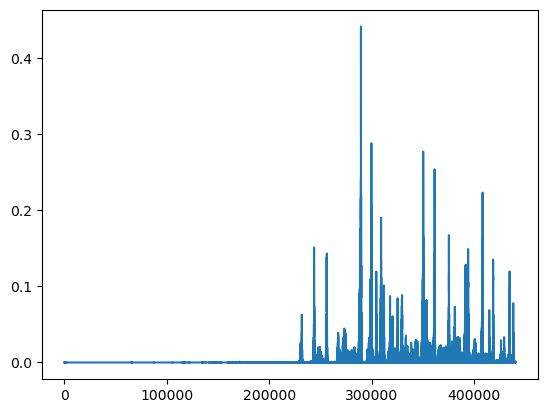

In [42]:
plt.plot(Pd)


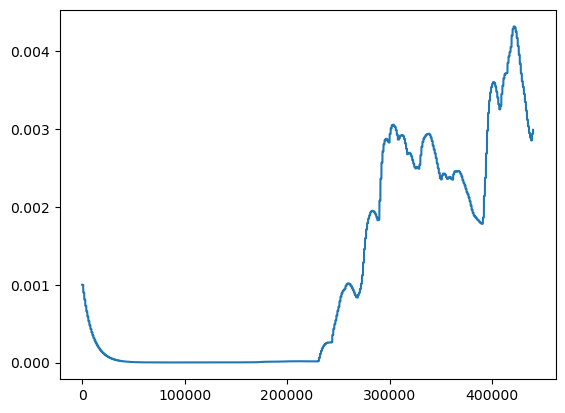

In [36]:
plt.plot(hB)
#plt.plot(Eg)

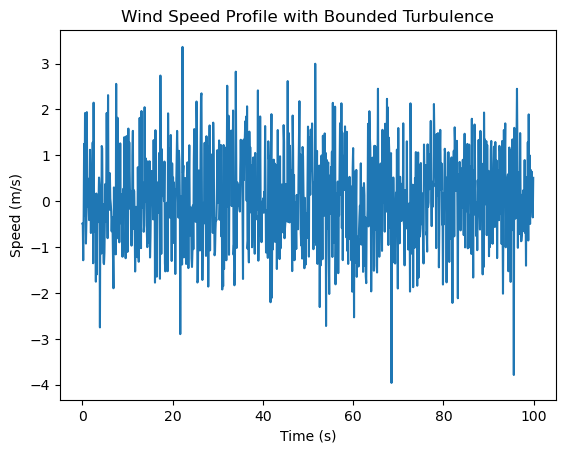

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_wind_profile(t_max, dt, v_avg, v_min_turb, v_max_turb):
    """
    Generates a wind speed profile v(t) = v_avg + v_tilde(t)
    where v_tilde is bounded turbulence.
    """
    time = np.arange(0, t_max, dt)
    n_steps = len(time)
    
    # 1. Generate random noise (turbulence)
    # Using a normal distribution centered at 0
    # You can adjust 'scale' to control how "rough" the wind is
    raw_noise = np.random.normal(loc=0, scale=1.0, size=n_steps)
    
    # 2. Scale and Clip the noise to respect the bounds from the paper
    # The article says v_tilde is bounded by v_min_turb and v_max_turb.
    # We map the noise so it physically fits in [v_min_turb, v_max_turb].
    # Note: Usually turbulence is +/- around 0. If the paper says bounds are positive,
    # it might mean the Magnitude of turbulence, or there's a typo. 
    # Let's assume symmetric bounds for physical realism: [-v_max, +v_max]
    # OR strictly following the paper's literal positive bounds if interpreted as magnitude.
    
    # Practical Interpretation: Turbulence adds to v_avg. 
    # Let's Clip the noise between the specific bounds mentioned.
    # Since v_min=5 and v_max=0.2 is impossible (min > max), 
    # we assume a typo: min=0.2, max=5.0
    
    v_tilde = np.clip(raw_noise, v_min_turb, v_max_turb) 
    
    # However, turbulence usually oscillates around 0. 
    # If the bounds are absolute limits of fluctuation magnitude:
    v_tilde = np.clip(raw_noise, -v_max_turb, v_max_turb)

    # 3. Create total wind
    v_total = v_avg + v_tilde
    
    return time, v_total, v_tilde

# Implementation based on Table 1 values (assuming typo correction min=0.2, max=5)
# v_tilde represents the FLUCTUATION.
t, v, v_turb = generate_wind_profile(t_max=100, dt=0.1, v_avg=10, v_min_turb=0.2, v_max_turb=5)

# Plotting to verify
plt.plot(t, v_turb)
plt.title("Wind Speed Profile with Bounded Turbulence")
plt.ylabel("Speed (m/s)")
plt.xlabel("Time (s)")
plt.show()

In [ ]:
import numpy as np

# Definir as matrizes fbc_Bd e x_fbc
fbc_Bd = np.array([[1, 1], [0, 0]])
x_fbc = np.array([[1], [0]])

# Usando a operação de multiplicação matricial inversa para encontrar K
# K = fbc_Bd @ inv(x_fbc)
# A operação precisa de uma transposição para que a multiplicação seja válida
# Podemos transpor x_fbc e resolver o sistema para encontrar K

np.linalg.pinv(fbc_Bd)


array([[0.5, 0. ],
       [0.5, 0. ]])

In [ ]:
np.random.seed(42)
random_values = np.random.normal(loc=2, scale=0.5, size=1)
random_values.item(0)

2.2483570765056164

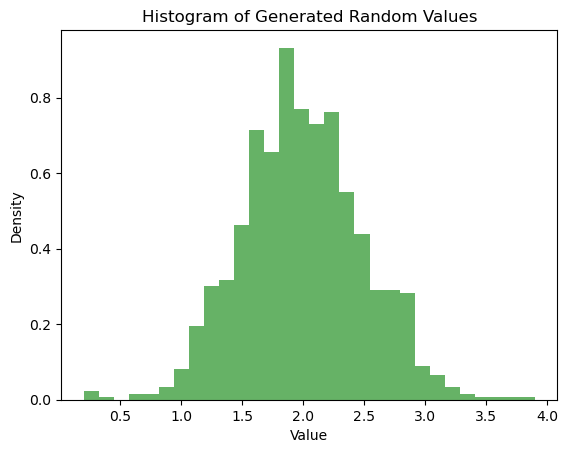

[1.45521622 2.12720643 3.36575471 1.69350857 1.83869499 1.84598645
 1.96578077 2.1908411  2.11520108 1.13646903]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the parameters for the normal distribution
mean = 2  # mean of the normal distribution
std_dev = 0.5  # standard deviation of the normal distribution
low = 0.2  # minimum value
high = 5  # maximum value
size = 1000  # number of random values to generate

# Generate random values following a normal distribution
random_values = np.random.normal(loc=mean, scale=std_dev, size=size)

# Clip values to lie within the specified range [low, high]
random_values = np.clip(random_values, low, high)

# Optionally, plot the generated values
plt.hist(random_values, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram of Generated Random Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Print a sample of the generated random values
print(random_values[:10])
